In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
import nana
from astropy import units as u

In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
lc = lc_collection.stitch()
total_observation_time = lc.time[-1] - lc.time[0]
print(total_observation_time)
delta_f = (1/total_observation_time).value
print(delta_f)

1470.4622572100852
0.0006800582572566702


In [22]:
sampling_rate_days= np.median(np.diff(lc.time))
f_max = 1 / (sampling_rate_days) #in days

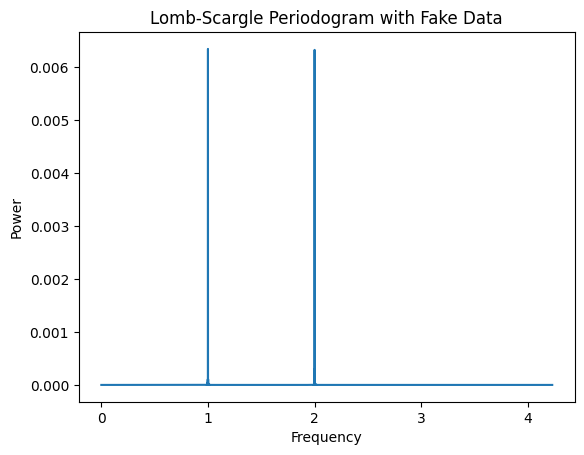

In [26]:
##Example with Fake Data to Get Correct Units
##Cannot Strip Units because lightkurve automatically adds units when using the to_periodogram function

##using LightKurve Periodogram function, WITH DAYS!
T_obs = 1 / delta_f
time = np.arange(0, T_obs, sampling_rate_days.value)
flux =  1+ 0.01 * np.cos(2 * np.pi * time) + 0.01* np.cos(4 * np.pi * time) + 0.001 * np.random.normal(size=time.shape) #fake flux data

lc_fake = lk.LightCurve(time=time, flux=flux) #light curve will automatically assume time is in days
frequency_grid_fake = np.arange(delta_f, f_max.value, delta_f) 

pg_fake2 = lc_fake.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid_fake
)


fakefreq2 = np.array(pg_fake2.frequency.to(1/u.day).value) ##adding units here is key!!! otherwise it will automatically plot in microhertz
#fakefreq2 = np.array(pg_fake2.frequency.value) #when using this fakefreq it plots in microhertz
fakepow2 = np.array(pg_fake2.power.value)  

plt.close('all')
plt.plot(fakefreq2, fakepow2)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Fake Data")
plt.show()

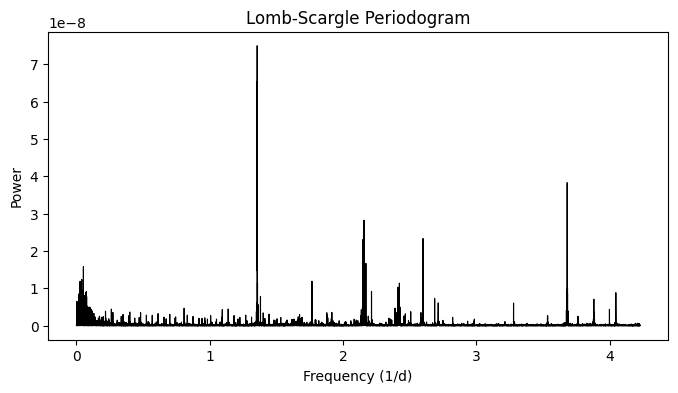

In [25]:
frequency_grid = np.arange(delta_f, f_max_no_units, delta_f) 

pg_test = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

freq_values = np.array(pg_test.frequency.to(1/u.day).value)  
freq_values_microhertz = np.array(pg_test.frequency.value)  
power_values = np.array(pg_test.power.value)  

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8) 
plt.xlabel("Frequency (1/d)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()


In [15]:
indices = nana.get_started(100, freq_values, power_values)
print(indices)
print(len(indices))

[23088 23103 62667 36727 44265 36563 36970   904   690 30084   475 23129
 41244 41069 62709   714 62618 37686  1276 68880  1194   429   287   892
   524  1098 23510  1313  1289  1135 45748 66073  1241   538    81   821
   775 23062 46204 55821   857   344 23038 30101 23199  1181   728 36824
   940  1337   368 36536   303  1666  1490   489 41320 23152   565  1764
 40684 13759 62682 46189 19386  4473 62694  1604 68064 18640  1942 36386
  1168   764 36697 36673   441  1263 62570   403 23073   843   796 62757
 36761   502  2007  3726   750 66038 22990 42691 41259   675  6825 30122
  1408 32622   106  4664]
100


In [16]:
def threshold20(indices, xs, ys): #looking at plus, minus 20 around peak
    good_peaks = []
    peak_multiples = 0
    med_med = []
    for i in indices:
        leftside = ys[i-20:i]  
        rightside = ys[i+1:i+21]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        print("index:", i, "median:", median,"multiple:", ys[i]/median)
        peak_multiples += ys[i]/median
        med_med.append(ys[i]/median)
        if ys[i] > 5*median:
            good_peaks.append(i)
            print("good peak identified")
    print("average multiple = ",peak_multiples/len(indices))
    median_median = np.nanmedian(med_med)
    print("median multiple:", median_median)
    return np.array(good_peaks)

In [17]:
good_peaks = threshold20(indices, freq_values, power_values)

index: 23088 median: 2.7753023449450585e-08 multiple: 2.70235826302779
index: 23103 median: 2.7753023449450585e-08 multiple: 2.3598940122691183
index: 62667 median: 3.070814375142247e-09 multiple: 12.481175919166265
good peak identified
index: 36727 median: 3.421017837249161e-09 multiple: 8.26158858443543
good peak identified
index: 44265 median: 2.3612140687021955e-09 multiple: 9.894033060250315
good peak identified
index: 36563 median: 1.6144212335619574e-09 multiple: 14.273757376268868
good peak identified
index: 36970 median: 1.4740243875729327e-09 multiple: 11.326504499356476
good peak identified
index: 904 median: 5.381634978995598e-09 multiple: 2.944244507314249
index: 690 median: 2.629033697350838e-09 multiple: 4.70347471827473
index: 30084 median: 3.276797891041818e-09 multiple: 3.6362318379230745
index: 475 median: 2.0839153666649755e-09 multiple: 5.714855891872161
good peak identified
index: 23129 median: 2.561367391876707e-09 multiple: 4.474671354830598
index: 41244 median:

In [27]:
def threshold10(indices, xs, ys): #looking at plus minus 10 around peak
    good_peaks = []
    peak_multiples = 0
    med_med = []
    for i in indices:
        leftside = ys[i-10:i]  
        rightside = ys[i+1:i+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        print("index:", i, "median:", median,"multiple:", ys[i]/median)
        peak_multiples += ys[i]/median
        med_med.append(ys[i]/median)
        if ys[i] > 5*median:
            good_peaks.append(i)
            print("good peak identified")
    print("average multiple = ",peak_multiples/len(indices))
    median_median = np.nanmedian(med_med)
    print("median multiple:", median_median)
    return np.array(good_peaks)

In [28]:
good_peaks10= threshold10(indices, freq_values, power_values)

index: 23088 median: 2.8467569341332426e-08 multiple: 2.6345281307082082
index: 23103 median: 2.7753023449450585e-08 multiple: 2.3598940122691183
index: 62667 median: 1.49393612660049e-08 multiple: 2.565529660124791
index: 36727 median: 1.5010668720115974e-08 multiple: 1.8828636110989525
index: 44265 median: 9.952513225599516e-09 multiple: 2.3473397651938726
index: 36563 median: 8.457729996815835e-09 multiple: 2.724591231883215
index: 36970 median: 7.13044411213975e-09 multiple: 2.3414451604187514
index: 904 median: 7.1539244274008986e-09 multiple: 2.214847163689516
index: 690 median: 3.6210017698194017e-09 multiple: 3.4149647846205675
index: 30084 median: 5.4940629008044865e-09 multiple: 2.168740517350233
index: 475 median: 2.5822250953508018e-09 multiple: 4.612020862468756
index: 23129 median: 3.121948655641318e-09 multiple: 3.6711933993268877
index: 41244 median: 4.344082353795717e-09 multiple: 2.624373494869995
index: 41069 median: 3.994753400934555e-09 multiple: 2.5819642546673784

In [29]:
#top 10 peak indices
topten =  nana.get_started(10, freq_values, power_values)
print(topten)

[23088 23103 62667 36727 44265 36563 36970   904   690 30084]


In [31]:
print(freq_values[topten])

[1.35664114 1.3575225  3.68218577 2.15802832 2.60093884 2.14839217
 2.17230628 0.05317512 0.04060111 1.76770535]


In [34]:
#ratio of  d2y/dx2 at peak) / (y_peak)
#I'm expecting ratios 10^6, but now its 10^7

xs_refined, ys_refined, second_derivative = nana.refine_peaks(freq_values, power_values, topten)
ratio = (second_derivative/ys_refined)
print("this is ratio of (d2y/dx2 at peak) / (y_peak):", ratio)

this is ratio of (d2y/dx2 at peak) / (y_peak): [-18751465.3264071  -18790821.38689204 -16123112.80267958
 -11967131.87380084 -14944365.12276956 -17088331.32529082
 -14789665.09540618 -17534331.84552378 -19705591.79256916
 -13994839.48883486]
